In [1]:
# Import torch
import torch

# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

In [2]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

RANDOM_SEED = 42
X, y = make_moons(n_samples=1000, noise = 0.07, random_state=RANDOM_SEED)
X[:5], y[:5]

(array([[-0.03341062,  0.4213911 ],
        [ 0.99882703, -0.4428903 ],
        [ 0.88959204, -0.32784256],
        [ 0.34195829, -0.41768975],
        [-0.83853099,  0.53237483]]),
 array([1, 1, 1, 1, 0], dtype=int64))

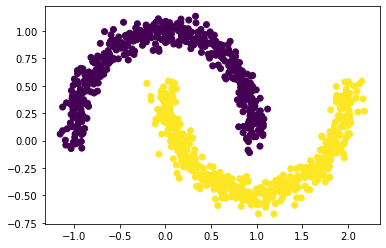

In [3]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
plt.scatter( X[:, 0], X[:, 1], c=y);

In [4]:
# Turn data into tensors of dtype float
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [5]:
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    ## Your code here ##
    def __init__(self, input_features, hidden_units, output_features):
      super().__init__()

    ## VERSION1
    #   self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_units)
    #   self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
    #   self.layer3 = nn.Linear(in_features=hidden_units, out_features=output_features)
    #   self.relu = nn.ReLU()

    # def forward(self, x):
    #     ## Your code here ##
    #     return self.layer3(self.relu(self.layer2self.relu(self.layer1(x))))

    ## VERSION 2
      self.linear_layer_stack = nn.Sequential(
          nn.Linear(in_features=input_features, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
      return self.linear_layer_stack(x)

# Instantiating the model
model_0 = MoonModelV0(2, 10, 1).to(device)
model_0

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [6]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid layer built-in

optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of model to optimize
                            lr=0.1) # learning rate

In [7]:
# What's coming out of our model?
y_logits = model_0(X_train.to(device))

# logits (raw outputs of model)
print("Logits:", y_logits[:5].squeeze())

y_pred_probs = torch.sigmoid(y_logits).squeeze()
# Prediction probabilities
print("Pred probs:", y_pred_probs[:5])
## Your code here ##

# Prediction labels
print("Pred labels:", torch.round(y_pred_probs)[:5].squeeze())

Logits: tensor([0.4232, 0.0424, 0.0420, 0.0490, 0.3454], grad_fn=<SqueezeBackward0>)
Pred probs: tensor([0.6042, 0.5106, 0.5105, 0.5123, 0.5855], grad_fn=<SliceBackward>)
Pred labels: tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)


In [8]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device

In [9]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
EPOCHS = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(1,EPOCHS+1):
  ### Training
  model_0.train()

  # 1. Forward pass (logits output)
  y_logits = model_0(X_train).squeeze()
  # Turn logits into prediction probabilities
  y_pred_probs = torch.sigmoid(y_logits)
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int()) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
      y_logits_test = model_0(X_test).squeeze()
    # Turn logits into prediction probabilities
      y_pred_probs_test = torch.sigmoid(y_logits_test)
    # Turn the test logits into prediction labels
      y_pred_test = torch.round(y_pred_probs_test)

    # 2. Caculate the test loss/acc
      test_loss = loss_fn(y_logits_test, y_test) # loss = compare model raw outputs to desired model outputs
      test_acc = acc_fn(y_pred_test, y_test.int())

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")

Epoch: 100 | Loss: 0.28 Acc: 0.87 | Test loss: 0.29 Test acc: 0.85
Epoch: 200 | Loss: 0.24 Acc: 0.89 | Test loss: 0.24 Test acc: 0.89
Epoch: 300 | Loss: 0.23 Acc: 0.89 | Test loss: 0.22 Test acc: 0.89
Epoch: 400 | Loss: 0.21 Acc: 0.90 | Test loss: 0.20 Test acc: 0.91
Epoch: 500 | Loss: 0.18 Acc: 0.92 | Test loss: 0.17 Test acc: 0.93
Epoch: 600 | Loss: 0.14 Acc: 0.94 | Test loss: 0.13 Test acc: 0.95
Epoch: 700 | Loss: 0.10 Acc: 0.97 | Test loss: 0.09 Test acc: 0.98
Epoch: 800 | Loss: 0.06 Acc: 0.99 | Test loss: 0.06 Test acc: 0.99
Epoch: 900 | Loss: 0.04 Acc: 1.00 | Test loss: 0.04 Test acc: 1.00
Epoch: 1000 | Loss: 0.03 Acc: 1.00 | Test loss: 0.03 Test acc: 1.00


In [10]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

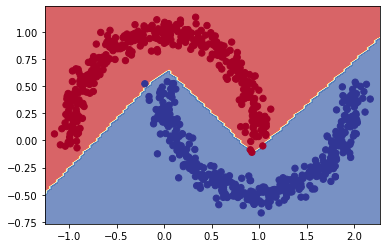

In [11]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(model_0, X_train, y_train)